In [1]:
from utils_filter import *
from utils_datetime import *
from utils_plotting import *
from datetime import timedelta
import xarray as xr
import geopandas as gp
import pandas as pd


In [19]:
df = xr.open_dataset('data/pph/all_pph.nc')

In [ ]:
totals = df['p_perfect_totalsvr'].sum(dim = ['x', 'y'])

In [35]:
totals[8500:].rolling(time=91, center=True).sum()

<xarray.DataArray 'p_perfect_totalsvr' (time: 7936)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-10T12:00:00 ... 2023-12-31T12:00:00

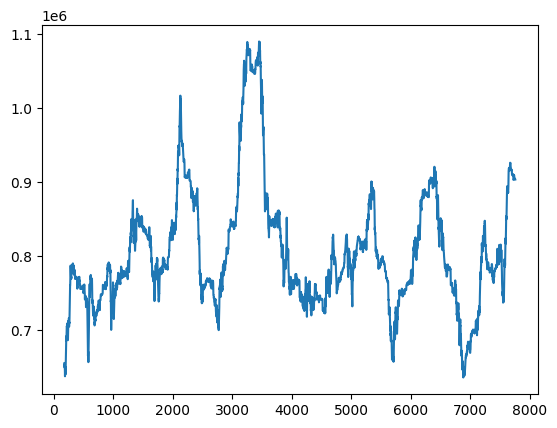

In [37]:
plt.plot(totals[8500:].rolling(time=365, center=True).sum())

In [2]:
df = xr.open_dataset('data/contingency/contingency.nc')

In [17]:
a = df.sel(time = '201905200000', hazard = "All Hazard").load()['a']
b = df.sel(time = '201905200000', hazard = "All Hazard").load()['b']
c = df.sel(time = '201905200000', hazard = "All Hazard").load()['c']
d = df.sel(time = '201905200000', hazard = "All Hazard").load()['d']

In [18]:
a

<xarray.DataArray 'a' ()>
array(13.27112765)
Coordinates:
    time     <U12 '201905200000'
    hazard   <U10 'All Hazard'

In [13]:
a, b, c, d, a+b, c+d, a+c, b+d

(<xarray.DataArray 'a' ()>
 array(13.27112765)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray 'b' ()>
 array(24.22887235)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray 'c' ()>
 array(38.72887235)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray 'd' ()>
 array(5968.77112765)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray ()>
 array(37.5)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray ()>
 array(6007.5)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray ()>
 array(52.)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard',
 <xarray.DataArray ()>
 array(5993.)
 Coordinates:
     time     <U12 '201905200000'
     hazard   <U10 'All Hazard')

In [ ]:
data_location = 'data'
moderate = False # only consider moderate days
outlooks, pph, reports = read_datasets(data_location, 'moderate')



In [ ]:
output_location = 'plots/daily/20190520'
categories = ['hail', 'wind', 'tor']
pph_day = pph.loc[dict(time = '2019-05-20T12:00:00')]
plot_pph_day_temp(pph_day, output_location, categories, show = True)

In [ ]:
outlooks[outlooks['DATE'] == '201804020000']

In [22]:
def plot_pph_day_temp(pph_date, output_location, categories, show = False):
    for category in categories:
        pph_date_category = pph_date[['p_perfect_' + category, 'lat', 'lon']]
        pph_date_category_sig = pph_date[['p_perfect_sig_' + category, 'lat', 'lon']]

        
        # credit: https://atlas.niu.edu/pperfect/BAMS/notebook_sample.html
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[0,2], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[2,5,10,15,30,45,60,100], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            plt.annotate('PPER Max\n'+str(pph_date_category['p_perfect_' + category].values[:,:].max().round(1))+'%', xy=(0.88, 0.3), xycoords="figure fraction",
                        va="center", ha="center", color='white',fontsize=12,
                        bbox=dict(boxstyle="round", fc="k"))
        except:
            plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
            
        try:
            plt.contourf(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                    levels=[10,100], colors='none', hatches=['////'],
                    transform=cp.crs.PlateCarree())
            plt.contour(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                    levels=[10,100], colors=['k'],
                    transform=cp.crs.PlateCarree())
        except:
            pass

        if category == 'tor':
            cat_title = 'Tornado'
        elif category == 'hail':
            cat_title = 'Hail'
        else:
            cat_title = 'Wind'

        ax.set_extent([-121, -71, 23, 50])
        plt.title('24 Hour Practically Perfect Hindcast for ' + cat_title)
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        plt.savefig(output_location + '/pph_' + category + '.png')
        if not show:
            plt.close()

In [2]:
import geopandas as gp

In [ ]:
# Read convective outlooks into outlooks
outlook_raw_location = 'raw_data/outlooks'
year_list = [[1987, 1991], [1992, 1999], [2000, 2007], [2008, 2015], [2016, 2023]]
for years, i in zip(year_list, range(len(year_list))):
    print('reading file ' + str(i) + ', years ' + str(years[0]) +'-' + str(years[1]))
    if i == 0:
        outlooks_original = gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359')
    else:
        outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))
print('files read')
    
outlooks_original

In [ ]:
# print 
outlooks_original[outlooks_original['ISSUE'] == '201903021200']

In [9]:
def create_dates(datetimes, shift):
    # converts list of datetime object to list of dates (YMD)
    # TODO: does this cause end of month issue? But only sometimes????
    for datetime, i in zip(datetimes, range(len(datetimes))):
        days = timedelta(shift)
        if i == 0:
            ret = [datetime.date() + days]
        else:
            ret.append(datetime.date() + days)
    return ret

def parse_datetime(date_strings):
    # convertes list of datetime strings (format used for outlooks, %Y%m%d%H%M) to list of datetime objects
    for date_string, i in zip(date_strings, range(len(date_strings))):
        if i == 0:
            ret = [dt.strptime(date_string, "%Y%m%d%H%M")]
        else:
            ret.append(dt.strptime(date_string, "%Y%m%d%H%M"))
        #if np.mod(i, 10000) == 0:
        #    print(i)
        #    print(dt.strptime(date_string, "%Y%m%d%H%M"))
    return ret

In [ ]:
pph

In [11]:
outlooks = outlooks_original
outlooks['ISSUE'] = parse_datetime(outlooks['ISSUE'])
outlooks['EXPIRE'] = parse_datetime(outlooks['EXPIRE'])
outlooks['PRODISS'] = parse_datetime(outlooks['PRODISS'])
# print

In [13]:
outlooks['DATE'] = create_dates(outlooks['EXPIRE'], -1)

In [ ]:
hazard_types= ['Wind', 'Hail', 'Tornado', 'Sig Wind', 'Sig Hail', 'Sig Tornado', 'Total Reports', 'Total Sig'] # TODO add true/false

report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        hazard=(['hazard'], hazard_types)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('time', 'y', 'x', 'hazard'), np.full((len(report_dataset['time']), len(report_dataset['y']), len(report_dataset['x']), len(hazard_types)), 0)))


In [ ]:
data_location = 'data'
gp.read_file(data_location + '/storm_reports/all_reports.csv')

In [ ]:
pd.read_csv(data_location + '/storm_reports/all_reports.csv')

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(100)
for true_prob in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    pod = np.empty(11)
    far = np.empty(11)
    for forecast_prob, i in enumerate([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]):
        pod = forecast_prob
        far = forecast_prob
        
        
    